In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as stats 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier 

Data Cleaning and Preparation

In [2]:
# read in the flights data
df_flight = pd.read_csv('data/flights.csv', nrows=2000001,low_memory=False) 
df_flight.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# read in the airlines and airports data
df_airline = pd.read_csv('data/airlines.csv') 
df_airport = pd.read_csv('data/airports.csv')  
df_airline.head() 
df_airport.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [4]:
# Drop duplicates, check shape and dtypes
df_flight.drop_duplicates(inplace=True)
df_flight.shape
df_flight.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object

In [5]:
# Count the number of missing values in each column
null_counts = df_flight.isnull().sum()  
null_counts

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER               8836
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           47208
DEPARTURE_DELAY          47208
TAXI_OUT                 48248
WHEELS_OFF               48248
SCHEDULED_TIME               4
ELAPSED_TIME             53364
AIR_TIME                 53364
DISTANCE                     0
WHEELS_ON                49734
TAXI_IN                  49734
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             49734
ARRIVAL_DELAY            53364
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    1951351
AIR_SYSTEM_DELAY       1617701
SECURITY_DELAY         1617701
AIRLINE_DELAY          1617701
LATE_AIRCRAFT_DELAY    1617701
WEATHER_DELAY          1617701
dtype: int64

In [6]:
# Drop columns with more than 1 million missing values
columns_to_drop = null_counts[null_counts > 1000000].index
df_flight.drop(columns=columns_to_drop, inplace=True)  
df_flight.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0


In [7]:
# Check data distribution of each column
pd.set_option('display.float_format', '{:.2f}'.format)
df_flight.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
count,2000001.00,2000001.00,2000001.00,2000001.00,2000001.00,2000001.00,1952793.00,1952793.00,1951753.00,1951753.00,...,1946637.00,1946637.00,2000001.00,1950267.00,1950267.00,2000001.00,1950267.00,1946637.00,2000001.00,2000001.00
mean,2015.00,2.67,14.89,3.93,2224.10,1327.79,1335.84,9.37,16.15,1358.81,...,136.64,113.12,809.99,1481.19,7.37,1501.28,1486.73,5.03,0.00,0.02
std,0.00,1.23,8.86,1.98,1784.72,477.45,488.90,36.64,9.21,489.64,...,73.66,71.71,596.00,512.23,5.76,497.52,516.11,39.15,0.05,0.15
min,2015.00,1.00,1.00,1.00,1.00,1.00,1.00,-68.00,1.00,1.00,...,15.00,7.00,21.00,1.00,1.00,1.00,1.00,-87.00,0.00,0.00
25%,2015.00,2.00,7.00,2.00,748.00,920.00,925.00,-5.00,11.00,940.00,...,82.00,60.00,370.00,1104.00,4.00,1115.00,1108.00,-13.00,0.00,0.00
50%,2015.00,3.00,15.00,4.00,1700.00,1324.00,1331.00,-1.00,14.00,1344.00,...,119.00,94.00,646.00,1514.00,6.00,1524.00,1519.00,-4.00,0.00,0.00
75%,2015.00,4.00,23.00,6.00,3415.00,1726.00,1736.00,8.00,19.00,1750.00,...,169.00,144.00,1050.00,1913.00,9.00,1918.00,1918.00,9.00,0.00,0.00
max,2015.00,5.00,31.00,7.00,9794.00,2359.00,2400.00,1988.00,225.00,2400.00,...,766.00,690.00,4983.00,2400.00,202.00,2400.00,2400.00,1971.00,1.00,1.00


In [8]:
# Drop columns with over-concentrated data 
# Drop null values in ARRIVAL_DELAY column
df_flight.drop(columns=["DIVERTED","CANCELLED"], inplace=True)    
df_flight = df_flight.dropna(subset=["ARRIVAL_DELAY"]) 
df_flight.shape 
df_flight.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,15.00,205.00,194.00,169.00,1448,404.00,4.00,430,408.00,-22.00
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,14.00,280.00,279.00,263.00,2330,737.00,4.00,750,741.00,-9.00
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,34.00,286.00,293.00,266.00,2296,800.00,11.00,806,811.00,5.00
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,30.00,285.00,281.00,258.00,2342,748.00,8.00,805,756.00,-9.00
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,35.00,235.00,215.00,199.00,1448,254.00,5.00,320,259.00,-21.00


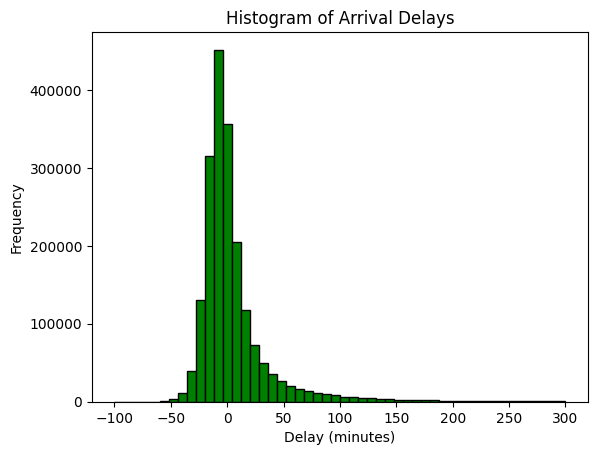

In [9]:
# Plot the histogram of ARRIVAL_DELAY, the delay has a long tail on the right, which means most of the flights are on time
plt.hist(df_flight['ARRIVAL_DELAY'], bins=50, color='green', edgecolor='black', range=[-100, 300])

plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')

plt.show()

In [10]:
# Check the proportion of delayed flights, using the standard from FAA, 
# a flight is considered delayed when it arrives 15 minutes later than the scheduled time
df_flight[df_flight.ARRIVAL_DELAY > 15].shape[0] / df_flight.shape[0]

0.1888410628175669

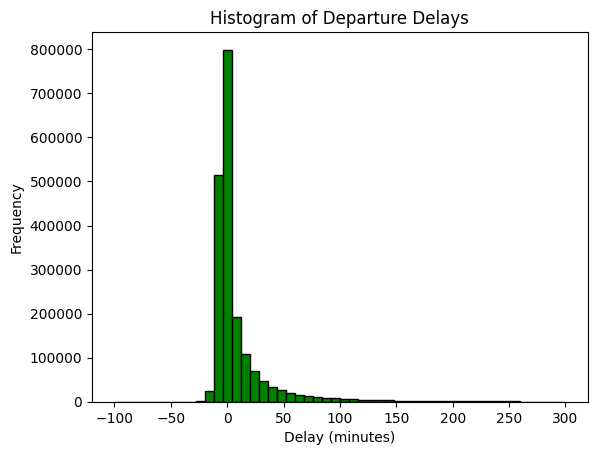

In [11]:
# Plot the histogram of DEPARTURE_DELAY, the delay has a long tail on the right, which means most of the flights are on time
plt.hist(df_flight['DEPARTURE_DELAY'], bins=50, color='green', edgecolor='black', range=[-100, 300])

plt.title('Histogram of Departure Delays')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')

plt.show()

In [12]:
# Create DELAYED column, 1 means delayed, 0 means on time
result=[] 
for row in df_flight['ARRIVAL_DELAY']:
  if row > 15:
    result.append(1)
  else:
    result.append(0)   
df_flight['DELAYED'] = result 
df_flight[df_flight.DELAYED == 1].shape[0] / df_flight.shape[0]

0.1888410628175669

In [13]:
# Create a new column called DATE, which is the combination of YEAR, MONTH and DAY columns
df_flight['DATE'] = pd.to_datetime(df_flight[['YEAR','MONTH', 'DAY']])  
df_flight.sort_values(by=['TAIL_NUMBER','DATE','SCHEDULED_DEPARTURE'], inplace=True) 
df_flight[['DATE','TAIL_NUMBER','AIRLINE','FLIGHT_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE','ARRIVAL_TIME','DEPARTURE_DELAY']].head(10)

,DATE,TAIL_NUMBER,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,ARRIVAL_TIME,DEPARTURE_DELAY
997100,2015-03-07,D942DN,DL,1056,SJC,MSP,615,1141.00,-2.00
1003244,2015-03-07,D942DN,DL,785,MSP,ATL,1300,1617.00,-1.00
1007200,2015-03-07,D942DN,DL,743,ATL,RDU,1730,1921.00,-1.00
1012057,2015-03-08,D942DN,DL,1482,RDU,ATL,710,826.00,-6.00
1014123,2015-03-08,D942DN,DL,2146,ATL,ROC,915,1142.00,25.00
1016786,2015-03-08,D942DN,DL,2146,ROC,ATL,1200,1430.00,25.00
1020221,2015-03-08,D942DN,DL,950,ATL,TPA,1530,1657.00,-1.00
1022542,2015-03-08,D942DN,DL,950,TPA,ATL,1745,1900.00,-1.00
1024724,2015-03-08,D942DN,DL,791,ATL,STL,1957,2102.00,20.00
6854,2015-01-01,N001AA,AA,1519,DFW,MEM,1345,1504.00,-3.00


In [14]:
# Convert time related columns to datetime format
df_flight['ARRIVAL_TIME'] = df_flight['ARRIVAL_TIME'].apply(lambda x: '{:04d}'.format(int(x)))
df_flight['SCHEDULED_DEPARTURE'] = df_flight['SCHEDULED_DEPARTURE'].apply(lambda x: '{:04d}'.format(int(x)))
df_flight['SCHEDULED_ARRIVAL'] = df_flight['SCHEDULED_ARRIVAL'].apply(lambda x: '{:04d}'.format(int(x)))

df_flight['SCHEDULED_DEPARTURE_DATETIME'] = pd.to_datetime(df_flight['DATE'].astype(str) + ' ' + df_flight['SCHEDULED_DEPARTURE'], format='%Y-%m-%d %H%M', errors='coerce')  
df_flight['SCHEDULED_ARRIVAL_DATETIME'] = pd.to_datetime(df_flight['DATE'].astype(str) + ' ' + df_flight['SCHEDULED_ARRIVAL'], format='%Y-%m-%d %H%M', errors='coerce')  
df_flight['ARRIVAL_DATETIME'] = pd.to_datetime(df_flight['DATE'].astype(str) + ' ' + df_flight['ARRIVAL_TIME'], format='%Y-%m-%d %H%M', errors='coerce') 
df_flight[['ARRIVAL_DATETIME']].head()

,ARRIVAL_DATETIME
997100,2015-03-07 11:41:00
1003244,2015-03-07 16:17:00
1007200,2015-03-07 19:21:00
1012057,2015-03-08 08:26:00
1014123,2015-03-08 11:42:00


In [15]:
# Calculate delayed time for the first leg of a connecting flight 
# and time difference between the first leg and the second leg of a connecting flight
df_flight['LAST_AIRPORT'] = df_flight['DESTINATION_AIRPORT'].shift(1)  
df_flight['LAST_ARRIVAL_DATETIME'] = df_flight['ARRIVAL_DATETIME'].shift(1)   
df_flight['LAST_SCHEDULED_ARRIVAL'] = df_flight['SCHEDULED_ARRIVAL_DATETIME'].shift(1)  
df_flight['LAST_TAIL_NUMBER'] = df_flight['TAIL_NUMBER'].shift(1)    

temp = df_flight[df_flight['ORIGIN_AIRPORT'] == df_flight['LAST_AIRPORT']] 
temp = temp[temp['TAIL_NUMBER'] == temp['LAST_TAIL_NUMBER']]  
temp = temp[temp['LAST_SCHEDULED_ARRIVAL'].dt.date == temp['SCHEDULED_DEPARTURE_DATETIME'].dt.date]
temp['TIME_DIFF'] = (temp['SCHEDULED_DEPARTURE_DATETIME'] - temp['LAST_ARRIVAL_DATETIME']).dt.total_seconds() / 60.0 
temp['LAST_ARRIVAL_DELAY'] = temp['ARRIVAL_DELAY'].shift(1) 
temp[['SCHEDULED_DEPARTURE_DATETIME','LAST_ARRIVAL_DATETIME','ARRIVAL_DATETIME','TAIL_NUMBER','AIRLINE','FLIGHT_NUMBER','ORIGIN_AIRPORT','LAST_AIRPORT','DESTINATION_AIRPORT','LAST_ARRIVAL_DELAY','TIME_DIFF']].head(10)

,SCHEDULED_DEPARTURE_DATETIME,LAST_ARRIVAL_DATETIME,ARRIVAL_DATETIME,TAIL_NUMBER,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,LAST_AIRPORT,DESTINATION_AIRPORT,LAST_ARRIVAL_DELAY,TIME_DIFF
1003244,2015-03-07 13:00:00,2015-03-07 11:41:00,2015-03-07 16:17:00,D942DN,DL,785,MSP,MSP,ATL,NaN,79.00
1007200,2015-03-07 17:30:00,2015-03-07 16:17:00,2015-03-07 19:21:00,D942DN,DL,743,ATL,ATL,RDU,-9.00,73.00
1014123,2015-03-08 09:15:00,2015-03-08 08:26:00,2015-03-08 11:42:00,D942DN,DL,2146,ATL,ATL,ROC,25.00,49.00
1016786,2015-03-08 12:00:00,2015-03-08 11:42:00,2015-03-08 14:30:00,D942DN,DL,2146,ROC,ROC,ATL,22.00,18.00
1020221,2015-03-08 15:30:00,2015-03-08 14:30:00,2015-03-08 16:57:00,D942DN,DL,950,ATL,ATL,TPA,10.00,60.00
1022542,2015-03-08 17:45:00,2015-03-08 16:57:00,2015-03-08 19:00:00,D942DN,DL,950,TPA,TPA,ATL,-1.00,48.00
1024724,2015-03-08 19:57:00,2015-03-08 19:00:00,2015-03-08 21:02:00,D942DN,DL,791,ATL,ATL,STL,-27.00,57.00
8812,2015-01-01 15:50:00,2015-01-01 15:04:00,2015-01-01 17:21:00,N001AA,AA,1519,MEM,MEM,DFW,16.00,46.00
19548,2015-01-02 10:45:00,2015-01-02 09:56:00,2015-01-02 12:17:00,N001AA,AA,1513,ATL,ATL,DFW,-9.00,49.00
21833,2015-01-02 13:00:00,2015-01-02 12:17:00,2015-01-02 14:14:00,N001AA,AA,2360,DFW,DFW,GUC,2.00,43.00


In [16]:
# Merge to original dataframe
temp.shape 
df_flight_1=pd.merge(df_flight, temp[['TAIL_NUMBER','AIRLINE','FLIGHT_NUMBER','SCHEDULED_DEPARTURE_DATETIME','TIME_DIFF','LAST_ARRIVAL_DELAY']], on=['TAIL_NUMBER','AIRLINE','FLIGHT_NUMBER','SCHEDULED_DEPARTURE_DATETIME'],how='left') 
df_flight_1.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DATE,SCHEDULED_DEPARTURE_DATETIME,SCHEDULED_ARRIVAL_DATETIME,ARRIVAL_DATETIME,LAST_AIRPORT,LAST_ARRIVAL_DATETIME,LAST_SCHEDULED_ARRIVAL,LAST_TAIL_NUMBER,TIME_DIFF,LAST_ARRIVAL_DELAY
0,2015,3,7,6,DL,1056,D942DN,SJC,MSP,0615,...,2015-03-07,2015-03-07 06:15:00,2015-03-07 11:56:00,2015-03-07 11:41:00,None,NaT,NaT,None,NaN,NaN
1,2015,3,7,6,DL,785,D942DN,MSP,ATL,1300,...,2015-03-07,2015-03-07 13:00:00,2015-03-07 16:26:00,2015-03-07 16:17:00,MSP,2015-03-07 11:41:00,2015-03-07 11:56:00,D942DN,79.00,NaN
2,2015,3,7,6,DL,743,D942DN,ATL,RDU,1730,...,2015-03-07,2015-03-07 17:30:00,2015-03-07 18:56:00,2015-03-07 19:21:00,ATL,2015-03-07 16:17:00,2015-03-07 16:26:00,D942DN,73.00,-9.00
3,2015,3,8,7,DL,1482,D942DN,RDU,ATL,0710,...,2015-03-08,2015-03-08 07:10:00,2015-03-08 08:50:00,2015-03-08 08:26:00,RDU,2015-03-07 19:21:00,2015-03-07 18:56:00,D942DN,NaN,NaN
4,2015,3,8,7,DL,2146,D942DN,ATL,ROC,0915,...,2015-03-08,2015-03-08 09:15:00,2015-03-08 11:20:00,2015-03-08 11:42:00,ATL,2015-03-08 08:26:00,2015-03-08 08:50:00,D942DN,49.00,25.00


In [17]:
# Sample the data for prediction
df_sample = df_flight_1.sample(n=500000, random_state=42)  

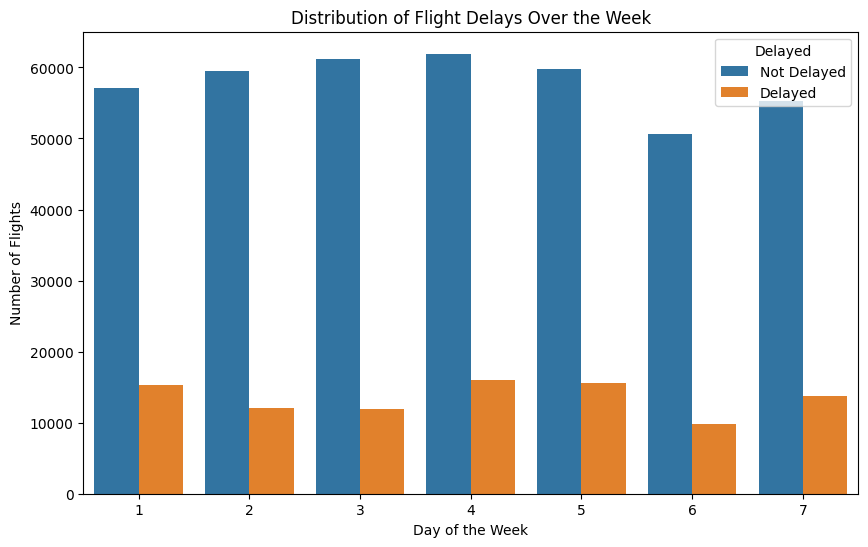

In [18]:
# Plot delayed situation over the week
plt.figure(figsize=(10, 6))
sns.countplot(x='DAY_OF_WEEK', hue='DELAYED', data=df_sample)

plt.title('Distribution of Flight Delays Over the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Flights')
plt.legend(title='Delayed',labels=['Not Delayed', 'Delayed'])


plt.show()

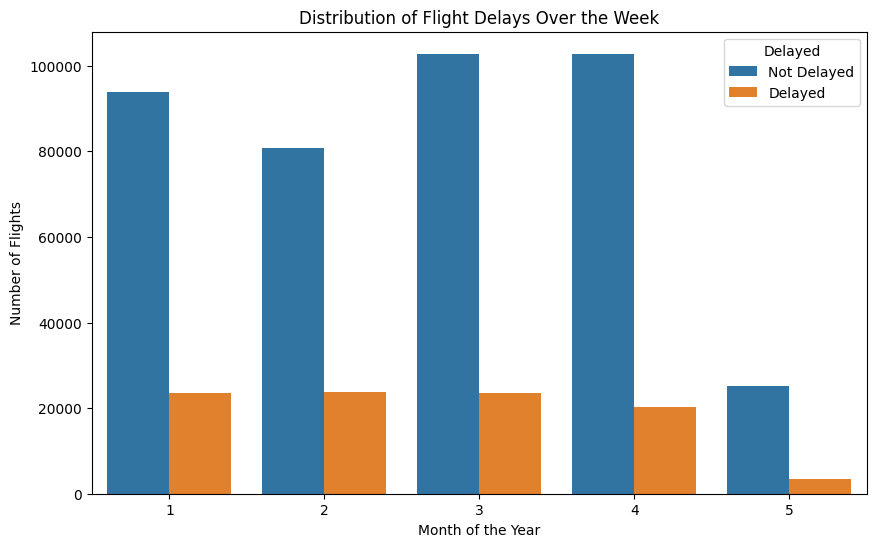

In [19]:
# Plot delayed situation over months
plt.figure(figsize=(10, 6))
sns.countplot(x='MONTH', hue='DELAYED', data=df_sample)

plt.title('Distribution of Flight Delays Over the Week')
plt.xlabel('Month of the Year')
plt.ylabel('Number of Flights')
plt.legend(title='Delayed',labels=['Not Delayed', 'Delayed'])


plt.show()

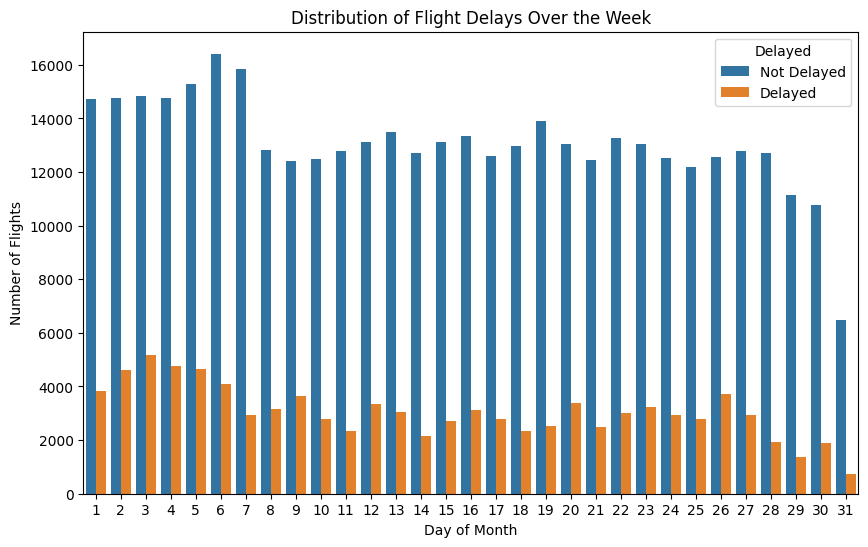

In [20]:
# Plot delayed situation over days
plt.figure(figsize=(10, 6))
sns.countplot(x='DAY', hue='DELAYED', data=df_sample)

plt.title('Distribution of Flight Delays Over the Week')
plt.xlabel('Day of Month')
plt.ylabel('Number of Flights')
plt.legend(title='Delayed',labels=['Not Delayed', 'Delayed'])


plt.show()

In [21]:
# Chi test for categorical variables, the p-value is less than 0.05, which means the variables are significant
def chi_test(col):
    ct = pd.crosstab(df_sample['DELAYED'], df_sample[col])
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(ct)
    print('The p-value for the {} chi test is {:.3f}'.format(col, p_val)) 

chi_test('DAY_OF_WEEK') 
chi_test('MONTH')  
chi_test('DAY') 
chi_test('DATE') 
chi_test('AIRLINE') 
chi_test('ORIGIN_AIRPORT') 
chi_test('DESTINATION_AIRPORT') 
chi_test('TAIL_NUMBER')

The p-value for the DAY_OF_WEEK chi test is 0.000
The p-value for the MONTH chi test is 0.000
The p-value for the DAY chi test is 0.000
The p-value for the DATE chi test is 0.000
The p-value for the AIRLINE chi test is 0.000
The p-value for the ORIGIN_AIRPORT chi test is 0.000
The p-value for the DESTINATION_AIRPORT chi test is 0.000
The p-value for the TAIL_NUMBER chi test is 0.000


In [22]:
# Split train and test data 
# Fill missing values with mean
df_train, df_test = train_test_split(df_sample, test_size=0.25, random_state=42)
df_train['LAST_ARRIVAL_DELAY'] = df_train['LAST_ARRIVAL_DELAY'].fillna(df_train['LAST_ARRIVAL_DELAY'].mean())
df_train['TIME_DIFF'] = df_train['TIME_DIFF'].fillna(df_train['TIME_DIFF'].mean())

<Axes: >

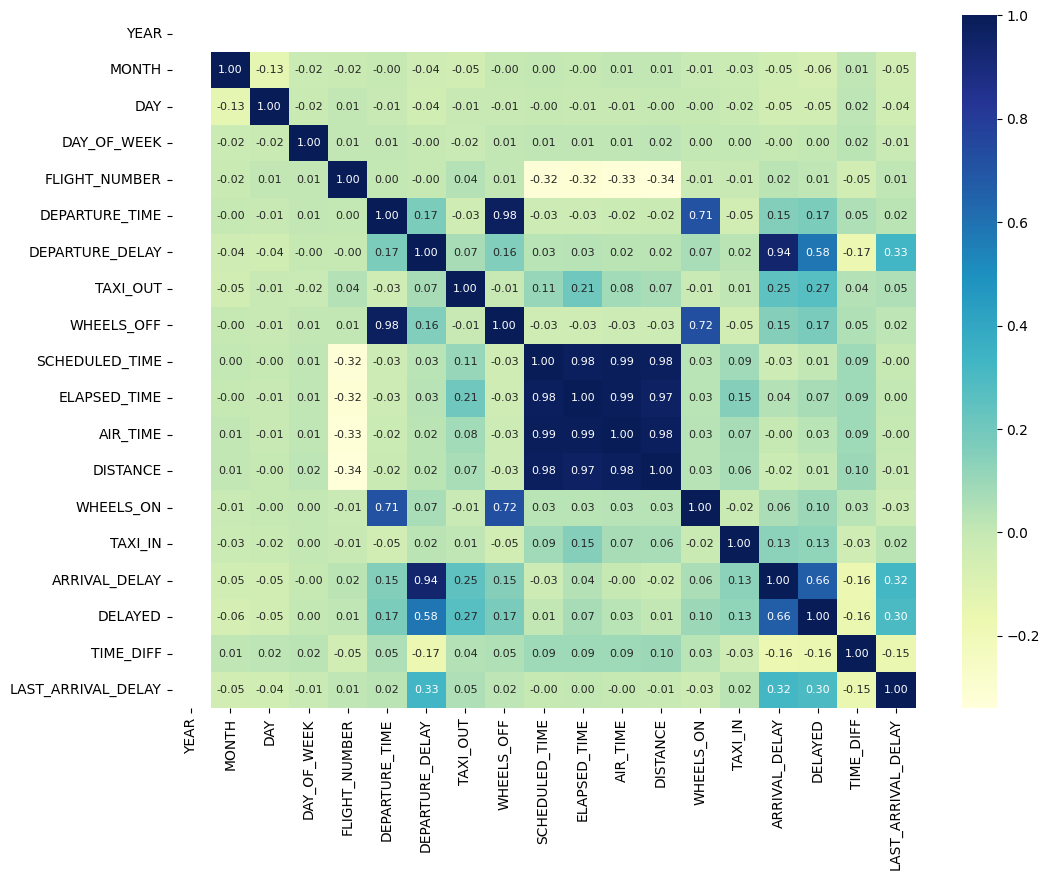

In [23]:
# Plot correlation matrix
plt.figure(figsize=(12, 9))
df_numeric = df_train.select_dtypes(include=[np.number])
corr = df_numeric.corr(method='pearson')
sns.heatmap(corr, annot=True, cmap="YlGnBu", annot_kws={"size": 8}, fmt=".2f")

In [24]:
# Drop columns with high correlation
df_train_final=df_train.drop(columns=["DATE","TAXI_OUT","WHEELS_OFF","SCHEDULED_TIME","ELAPSED_TIME","AIR_TIME","WHEELS_ON","TAXI_IN","SCHEDULED_ARRIVAL","ARRIVAL_TIME","ARRIVAL_DELAY", 
                                       "SCHEDULED_DEPARTURE_DATETIME","SCHEDULED_ARRIVAL_DATETIME","ARRIVAL_DATETIME","LAST_AIRPORT","LAST_ARRIVAL_DATETIME","LAST_SCHEDULED_ARRIVAL","LAST_TAIL_NUMBER"]) 
df_train_final.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,DISTANCE,DELAYED,TIME_DIFF,LAST_ARRIVAL_DELAY
1122054,2015,2,12,4,MQ,3196,N656MQ,ORD,TUL,1450,1448.00,-2.00,585,0,49.00,-6.00
577204,2015,2,26,4,OO,4521,N416SW,MSP,GRR,0958,1453.00,295.00,408,1,60.45,5.54
1341493,2015,3,1,7,UA,1567,N76522,ORD,LAS,1218,1319.00,61.00,1514,1,-2.00,41.00
1558783,2015,2,6,5,VX,874,N849VA,LAX,DAL,0710,706.00,-4.00,1246,0,60.45,5.54
865478,2015,2,20,5,UA,433,N548UA,OGG,SFO,2207,2206.00,-1.00,2338,0,93.00,19.00


In [25]:
# Convert SCHEDULED_DEPARTURE to minutes
def time_to_minutes(time_str):
    # Convert to hours and minutes
    hours = int(time_str[:2])
    minutes = int(time_str[2:])
    # Calculate total minutes
    return hours * 60 + minutes

df_train_final['SCHEDULED_DEPARTURE'] = df_train_final['SCHEDULED_DEPARTURE'].apply(time_to_minutes)

In [26]:
# Eliminate abnormal values
df_train_final=df_train_final[df_train_final.ORIGIN_AIRPORT.isin(df_airport.IATA_CODE)] 
df_train_final=df_train_final[df_train_final.DESTINATION_AIRPORT.isin(df_airport.IATA_CODE)] 

In [27]:
# Check any missing values
df_train_final.isnull().sum() 

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
DISTANCE               0
DELAYED                0
TIME_DIFF              0
LAST_ARRIVAL_DELAY     0
dtype: int64

In [28]:
# Check data types
df_train_final.dtypes 

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
DISTANCE                 int64
DELAYED                  int64
TIME_DIFF              float64
LAST_ARRIVAL_DELAY     float64
dtype: object

Model Training and Evaluation

In [29]:
# Choose features and target
X_train = df_train_final[['MONTH','DAY','DAY_OF_WEEK','AIRLINE','FLIGHT_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE','LAST_ARRIVAL_DELAY','TIME_DIFF']]
y_train = df_train_final['DELAYED']


categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create a pipeline to preprocess data 
# StandardScaler() standardizes features by removing the mean and scaling to unit variance.  
# It's being applied to numerical_cols,which means it will standardize all the numerical columns in the dataset. 
# OneHotEncoder() encodes categorical features as one-hot numeric arrays.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [30]:
# Train a logistic regression model
param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(max_iter=10000))])

grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)  
print("Best parameters for logistic regression:", grid_search_lr.best_params_)
print("Best ROC AUC for logistic regression:", grid_search_lr.best_score_) 

Best parameters for logistic regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best ROC AUC for logistic regression: 0.7505233625008682


In [31]:
# Train a decision tree model
param_grid_dt = {
    'classifier__max_depth': [3, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}  

dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier())])

grid_search_dt = GridSearchCV(dt_pipeline, param_grid_dt, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)  
print("Best parameters for decision tree:", grid_search_dt.best_params_)
print("Best ROC AUC for decision tree:", grid_search_dt.best_score_) 

Best parameters for decision tree: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Best ROC AUC for decision tree: 0.7916678239186264


In [32]:
# Train a random forest model
param_grid_rf = {
    'classifier__n_estimators': [100, 200], 
    'classifier__max_depth': [2, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
} 

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
]) 

grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train, y_train) 

print("Best parameters for random forest:", grid_search_rf.best_params_)
print("Best ROC AUC for random forest:", grid_search_rf.best_score_)

Best parameters for random forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best ROC AUC for random forest: 0.7830000435796288


In [33]:
# Train a xgboost model
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 15],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
}

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best ROC AUC for XGBoost:", grid_search_xgb.best_score_)

Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 15, 'classifier__n_estimators': 200}
Best ROC AUC for XGBoost: 0.844895448322705


In [34]:
# Train a lightgbm model
param_grid_lgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 15],
    'classifier__learning_rate': [0.01, 0.1, 0.2], 
    'classifier__num_leaves': [10, 20, 30]
}

lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier())
])

grid_search_lgb = GridSearchCV(lgb_pipeline, param_grid_lgb, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_lgb.fit(X_train, y_train)

print("Best parameters for LightGBM:", grid_search_lgb.best_params_)
print("Best ROC AUC for LightGBM:", grid_search_lgb.best_score_)

[LightGBM] [Info] Number of positive: 47185, number of negative: 202815
[LightGBM] [Info] Number of positive: 47184, number of negative: 202816
[LightGBM] [Info] Number of positive: 47185, number of negative: 202815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 618
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.188736 -> initscore=-1.458244
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features

In [35]:
# Preprocess test data
df_test['LAST_ARRIVAL_DELAY'] = df_test['LAST_ARRIVAL_DELAY'].fillna(df_test['LAST_ARRIVAL_DELAY'].mean())
df_test['TIME_DIFF'] = df_test['TIME_DIFF'].fillna(df_test['TIME_DIFF'].mean())   
df_test_final=df_test.drop(columns=["DATE","TAXI_OUT","WHEELS_OFF","SCHEDULED_TIME","ELAPSED_TIME","AIR_TIME","WHEELS_ON","TAXI_IN","SCHEDULED_ARRIVAL","ARRIVAL_TIME","ARRIVAL_DELAY", 
                                       "SCHEDULED_DEPARTURE_DATETIME","SCHEDULED_ARRIVAL_DATETIME","ARRIVAL_DATETIME","LAST_AIRPORT","LAST_ARRIVAL_DATETIME","LAST_SCHEDULED_ARRIVAL","LAST_TAIL_NUMBER"])  

df_test_final=df_test_final[df_test_final.ORIGIN_AIRPORT.isin(df_airport.IATA_CODE)] 
df_test_final=df_test_final[df_test_final.DESTINATION_AIRPORT.isin(df_airport.IATA_CODE)] 
df_test_final['SCHEDULED_DEPARTURE'] = df_test_final['SCHEDULED_DEPARTURE'].apply(time_to_minutes)  
X_test = df_test_final[['MONTH','DAY','DAY_OF_WEEK','AIRLINE','FLIGHT_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE','LAST_ARRIVAL_DELAY','TIME_DIFF']]
y_test = df_test_final['DELAYED']

In [36]:
# Fit the best logistic regression model for test data
best_model = grid_search_lr.best_estimator_
y_pred = best_model.predict(X_test)  
y_probs = best_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))  

roc_auc = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", roc_auc) 

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    101241
           1       0.78      0.21      0.33     23759

    accuracy                           0.84    125000
   macro avg       0.81      0.60      0.62    125000
weighted avg       0.83      0.84      0.80    125000

[[99813  1428]
 [18778  4981]]
ROC AUC Score: 0.7538858162268207


In [37]:
# Fit the best decision tree model for test data
best_model = grid_search_dt.best_estimator_
y_pred = best_model.predict(X_test)  
y_probs = best_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))  

roc_auc = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", roc_auc)

              precision    recall  f1-score   support

           0       0.87      0.99      0.93    101241
           1       0.86      0.38      0.53     23759

    accuracy                           0.87    125000
   macro avg       0.87      0.68      0.73    125000
weighted avg       0.87      0.87      0.85    125000

[[99818  1423]
 [14708  9051]]
ROC AUC Score: 0.7964902514631588


In [38]:
# Fit the best random forest model for test data
best_model = grid_search_rf.best_estimator_
y_pred = best_model.predict(X_test)  
y_probs = best_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))  

roc_auc = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", roc_auc)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91    101241
           1       0.98      0.13      0.23     23759

    accuracy                           0.83    125000
   macro avg       0.90      0.56      0.57    125000
weighted avg       0.86      0.83      0.78    125000

[[101165     76]
 [ 20664   3095]]
ROC AUC Score: 0.7786333959300924


In [39]:
# Fit the best xgboost model for test data
best_model = grid_search_xgb.best_estimator_
y_pred = best_model.predict(X_test)  
y_probs = best_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))  

roc_auc = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", roc_auc)

              precision    recall  f1-score   support

           0       0.88      0.98      0.93    101241
           1       0.85      0.42      0.56     23759

    accuracy                           0.88    125000
   macro avg       0.87      0.70      0.74    125000
weighted avg       0.87      0.88      0.86    125000

[[99527  1714]
 [13814  9945]]
ROC AUC Score: 0.8387668572557472


In [40]:
# Fit the best lightgbm model for test data
best_model = grid_search_lgb.best_estimator_
y_pred = best_model.predict(X_test)  
y_probs = best_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))  

roc_auc = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", roc_auc)

              precision    recall  f1-score   support

           0       0.88      0.98      0.93    101241
           1       0.86      0.42      0.56     23759

    accuracy                           0.88    125000
   macro avg       0.87      0.70      0.74    125000
weighted avg       0.87      0.88      0.86    125000

[[99646  1595]
 [13858  9901]]
ROC AUC Score: 0.8431933169944348


In [41]:
# Extract the LGBMClassifier from the pipeline
best_model = grid_search_lgb.best_estimator_
lgb_model = best_model.named_steps['classifier']

# Get the feature importances
importances = lgb_model.feature_importances_

# Get the transformed feature names
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Create a series for visualization
feature_importances = pd.Series(importances, index=feature_names)

# Sort the features by their importance
sorted_features = feature_importances.sort_values(ascending=False)

# Display the sorted features
print(sorted_features[:10])

num__DAY                        795
num__SCHEDULED_DEPARTURE        696
num__TIME_DIFF                  694
num__FLIGHT_NUMBER              518
num__LAST_ARRIVAL_DELAY         477
num__MONTH                      470
num__DAY_OF_WEEK                368
cat__AIRLINE_WN                  63
cat__DESTINATION_AIRPORT_SFO     35
cat__ORIGIN_AIRPORT_ORD          33
dtype: int32


In [42]:
# Extract the XGBClassifier from the pipeline
best_model = grid_search_xgb.best_estimator_
xgb_model = best_model.named_steps['classifier']

# Get the feature importances
importances = xgb_model.feature_importances_

# Get the transformed feature names
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Create a series for visualization
feature_importances = pd.Series(importances, index=feature_names)

# Sort the features by their importance
sorted_features = feature_importances.sort_values(ascending=False)

# Display the sorted features
print(sorted_features[:10])

num__TIME_DIFF                 0.02
cat__AIRLINE_HA                0.01
cat__DESTINATION_AIRPORT_HNL   0.01
cat__DESTINATION_AIRPORT_LGA   0.01
cat__AIRLINE_WN                0.00
cat__DESTINATION_AIRPORT_LGB   0.00
cat__ORIGIN_AIRPORT_SHV        0.00
cat__ORIGIN_AIRPORT_HNL        0.00
cat__ORIGIN_AIRPORT_JFK        0.00
cat__DESTINATION_AIRPORT_JFK   0.00
dtype: float32
